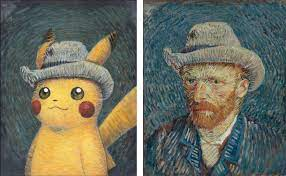

# <font color="#ebb73d" face="Comic Sans MS">Content - Notebook Part 1</font> 

- Part 0:  [Project Introduction](#1)
- Part 1:  [Import Packages and EDA](#2)   
  - 1.1  [Import Packages](#3)
  - 1.2  [EDA](#4)
- Part 2: [TPU, Load TFRecord data and Data Preprocessing](#5)
    - 2.1 [TPU](#6)
    - 2.2 [Load TFRecords Files and Data Preprocessing](#7)
- Part 3: [Basics about Autoencoders and GANs](#8)
- Rest of the notebook is [here](https://www.kaggle.com/code/jieshends2020/gan-painting-part-2) in part 2 of the notebook

Phote (not from Monet though) from [Pokémon x Van Gogh Museum](https://www.vangoghmuseum.nl/en/about/collaborate/van-gogh-museum-brand-licenses/collaboration-license-partners/van-gogh-museum-x-pokemon)




## <font face="Comic Sans MS" color=#ad2004 >Kaggle won't allow me to have notebook with large than 1MB, this notebook has 2 parts. This is the first part and the second part is [here](https://www.kaggle.com/code/jieshends2020/gan-painting-part-2)</font>

# <a id="1"></a>
<div style="text-align: center; background-color: #075674; font-size:80%; font-family:Comic Sans MS; padding: 5px;border-radius:10px 10px; color: #d3d3d3"> 
    <h1>Part 0: Introduction 🎨</h1>

</div>

<div style="background-color:#f4f4f4; padding: 10px;">
<span style="font-size: larger; color: black">
    
    
### Dataset Overview 
The dataset originates from a Kaggle competition project. As mentioned in the [dataset](https://www.kaggle.com/competitions/gan-getting-started/data) and [project description](https://www.kaggle.com/competitions/gan-getting-started/overview),The dataset provided for this competition consists of four main directories: 
- monet_tfrec: 300 sized 256x256 Monet painting images in tfrec formats
- monet_jpg: same  300 sized 256x256 Monet painting images in jpg formats
- photo_tfrec: 3078 sized 256x256 photo images in tfrec formats
- and photo_jpg: same 3078 sized 256x256 photo images in jpg formats

We'll use jpg files for EDA first and switch to tfrec for model building (TFRecord files are stored in a binary format so it's more efficient for final model use. 

### Project Goals, metric and focus 
Project goal: We will use a GAN network to generate photo images in the style of Monet. Submissions are evaluated on MiFID (Memorization-informed Fréchet Inception Distance), which is a modification from Fréchet Inception Distance (FID). The smaller MiFID is, the better your generated images are.
    
Beyond prediction: Gain insights and identify potential bottlenecks/challenges into the application of CycleGAN

### Model Training Approach and highlights
In this notebook, we encountered memory and time constraints during model training, leading to suboptimal tuning in initial tunings. Here is a very short introduction of model training we'll do:
- Baseline Model: We'll start with a simple CycleGAN structure that is a little simpler than the typical CycleGAN structure on papers. The generated images lack resemblance to either real photos or Monet paintings.

- First Tuning: We'll explore to add layers to find a good model. CycleGAN is very sensitive to hyper-parameters, so we'll spend lots of effect to find the best fitting ones (although with limitation of resources it's limitted to small epochs and batch sizes). However, overfitting remains a persist concern after changing model structure and hyper-parameter tuning.

- Second Tuning: To reduce overfiting, we'll turn to techniques like image augmentation and repeated sampling of Monet images.

- Final Tuning: We'll training as long as needed (and resources allow). With longer training time, we added learning rate scheduler. Also, we'll explore to use larger batch size (which we didn't use in tuning models due to memory resource).
    
    

# <a id="2"></a>
<div style="text-align: center; background-color: #075674; font-size:80%; font-family:Comic Sans MS; padding: 5px;border-radius:10px 10px; color: #d3d3d3"> 
    <h1>Part 1: EDA 🪞</h1>

</div>

## <a id="3"></a>

<div style="text-align: center; background-color: #f5db37; font-size:70%; font-family: Comic Sans MS; padding: 2px;border-radius:10px; color: #075674;">
    <h2>Part 1.1: Import Packages</h2>
</div>

In [1]:
# For some reason, it seems I need to install those when using TPU or packages won't be found sometimes...
!pip install seaborn
!pip install pyarrow

In [2]:
# Import packages
import os, cv2, re,logging,  warnings
from kaggle_datasets import KaggleDatasets
import numpy as np 
import pandas as pd
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print("TensorFlow version:", tf.__version__)

2024-04-09 03:52:27.336821: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-09 03:52:27.336956: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-09 03:52:27.529469: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.15.0


## <a id="4"></a>

<div style="text-align: center; background-color: #f5db37; font-size:70%; font-family: Comic Sans MS; padding: 2px;border-radius:10px; color: #075674;">
    <h2>Part 1.2: EDA</h2>
</div>

## <font color= #ad2004 face="Comic Sans MS"> Number of Images </font>

We could use TFRecords files right from the beginning. But to illustrate reading data in raw format also, we will start with raw file format (.jpg) first. As mentioned in [dataset description](https://www.kaggle.com/competitions/gan-getting-started/data), the tfrec and jpg directories contain the same images, so it shouldn't matter which one(s) we use for EDA.

In [3]:
# File directories
BASE_DIR = "../input/gan-getting-started/"
MONET_DIR = os.path.join(BASE_DIR, "monet_jpg")
PHOTO_DIR = os.path.join(BASE_DIR, "photo_jpg")

# Display number of files in Monet and Photo directories
print('Number of images in Monet directory: ', len(os.listdir(MONET_DIR)))
print('Number of images in photo directory: ', len(os.listdir(PHOTO_DIR)))

Number of images in Monet directory:  300
Number of images in photo directory:  7038


## <font color= #ad2004 face="Comic Sans MS"> Display Sample Images & Image Sizes</font>

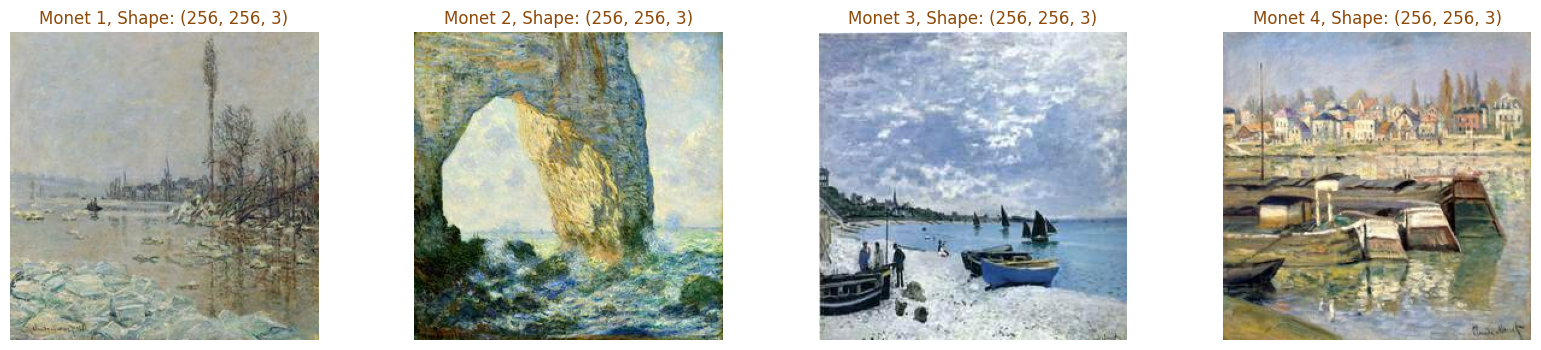

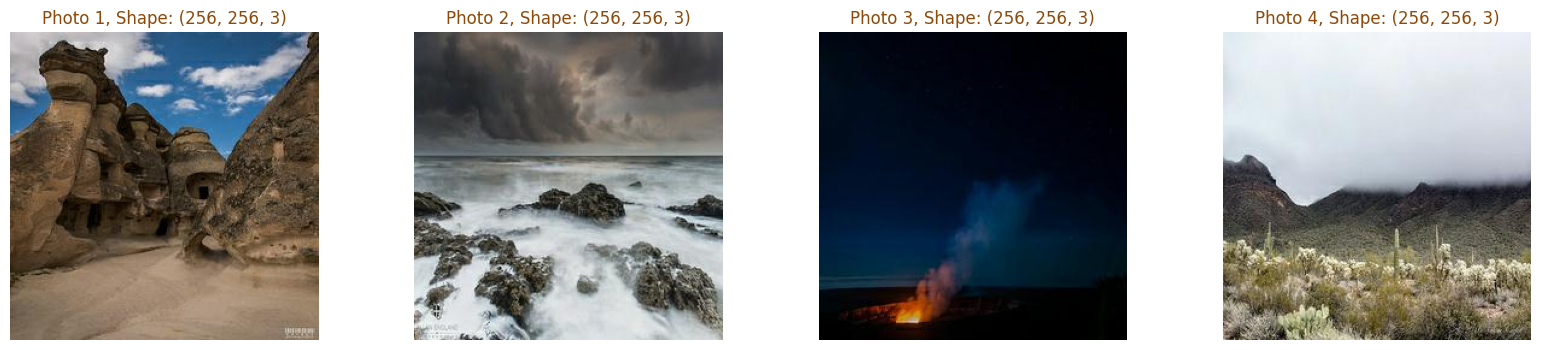

In [4]:
# Let's display some sample images, also image sizes info

# Function to display sample image 
def display_sample_images(file_path, num_samples=4, title=""):
    all_file_names= os.listdir(file_path)
    sample_file_names = np.random.choice(all_file_names, num_samples)
    
    fig, ax = plt.subplots(1, num_samples, figsize=(20, 4))
    for i, fn in enumerate(sample_file_names):
        sample_image_path = os.path.join(file_path, fn)
        image_decoded = cv2.imread(sample_image_path)
        image_decoded = cv2.cvtColor(image_decoded, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        ax[i].imshow(image_decoded)
        ax[i].axis('off')
            
        # Print image size in titles
        size_str = '{} {}, Shape: {}'.format(title,i+1,image_decoded.shape)
        ax[i].set_title(size_str, color='#8d4908')

    plt.show()

# Display some Monet
display_sample_images(file_path=MONET_DIR, title="Monet")
# Display some real Photo
display_sample_images(PHOTO_DIR, title='Photo')

## <font color= #ad2004 face="Comic Sans MS"> Images in Individual Color Chanels </font>

In [5]:
# Function to display sample images
def display_sample_images_chanels(file_path, num_samples=1, title=""):
    all_file_names= os.listdir(file_path)
    sample_file_names = np.random.choice(all_file_names, num_samples)
    
    fig, ax = plt.subplots(2*num_samples, 4, figsize=(20, 4*2*num_samples))
    for i, fn in enumerate(sample_file_names):
        sample_image_path = os.path.join(file_path, fn)
        image_decoded = cv2.imread(sample_image_path)
        image_decoded = cv2.cvtColor(image_decoded, cv2.COLOR_BGR2RGB )
        # Original image
        ax[i*2][0].imshow(image_decoded)
        ax[i*2][0].axis('off')
        ax[i*2][0].set_title(f'{title} {i+1}',color='#8d4908')
         
        for j in range(3):
            image_inChanel = image_decoded[:,:,j].reshape(-1)# extract array from inidividual color channel and convert to 1 D array
            ax[i*2][j+1].hist(image_inChanel,bins=25, color=['#ad2004', '#007446', '#13358f'][j], alpha=0.3)
            ax[i*2][j+1].set_title(f'{title} {i+1}',color='#8d4908')
        
        # Gray scale image
        ax[i*2+1][0].imshow(np.mean(image_decoded, axis=2),cmap="gray")
        ax[i*2+1][0].set_title(f'{title} {i+1}', color='#8d4908')
        
        # Red, Green, and Blue Chanels Image
        for k in range(3):
            image_individual_Chanel= np.full_like(image_decoded, 0)
            image_individual_Chanel[:, :, k] = image_decoded[:, :, k]
            ax[i*2+1][k+1].imshow(image_individual_Chanel)
            ax[i*2+1][k+1].set_title(f'{title} {i+1}', color='#8d4908')
       
    plt.show()

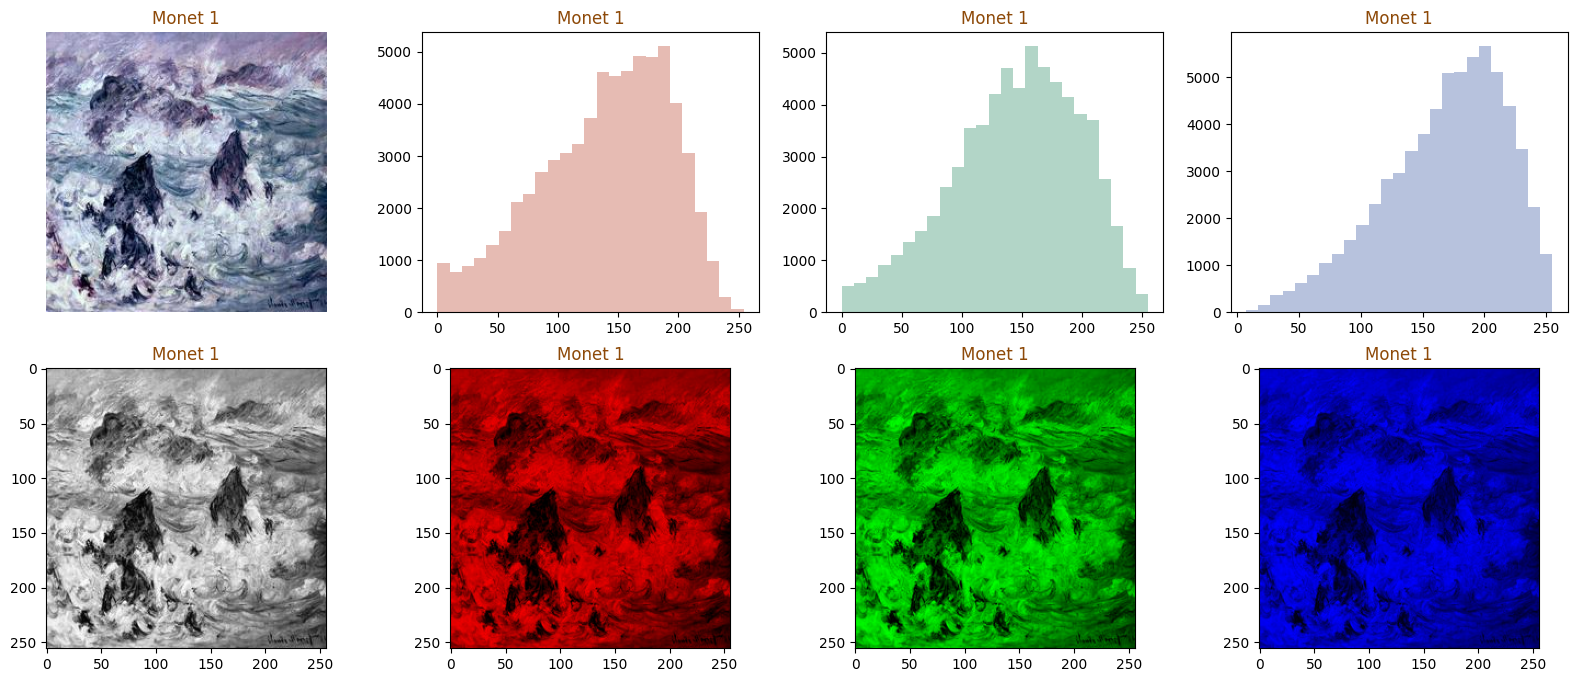

In [6]:
# Display Monet paintings in historgrams & images in different chanels
display_sample_images_chanels(file_path=MONET_DIR, title="Monet")

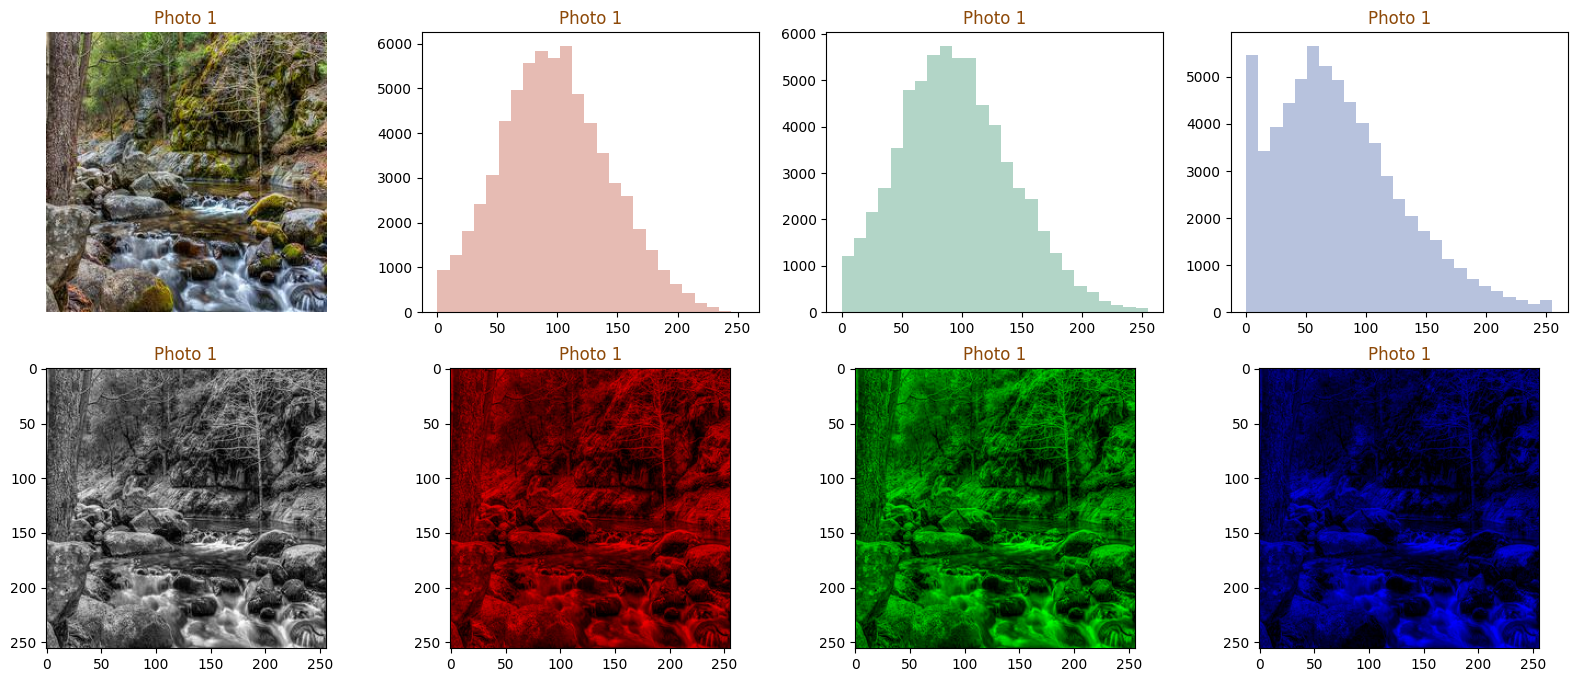

In [7]:
# Display real photos in historgrams & images in different chanels
display_sample_images_chanels(file_path=PHOTO_DIR, title="Photo")

## <font color= #ad2004 face="Comic Sans MS"> EDA Summary</font>
- There are **300 Monet paintings and 3078 photos**.
- Images have size of **(256, 256, 3)**. That is pixels have range of [0, 255], and we have 2 color channels for each images.
- Honestly, although it's fun, but by looking at histograms and images in different chanels, it's hard to find some sort of 'trend' of Monet paintings vs. photo. I guess we need complex deep neural network to figure things out!

# <a id="5"></a>
<div style="text-align: center; background-color: #075674; font-size:80%; font-family:Comic Sans MS; padding: 5px;border-radius:10px 10px; color: #d3d3d3"> 
    <h1>Part 2: Load TFRecord data and Data Preprocessing 🌼</h1>

</div>

<div style="background-color: #f4f4f4; padding: 10px;">
<span style="font-size: larger; color: black">
    
## <font color="#075674" face="Comic Sans MS">What to do in data preprocessing?</font>       

- From EDA, we found the pixels range is [0,255], we need to **scale/normalize them to the range [-1, 1]**. As for many scale/normalization methods, it ensures that all input features (pixel values) are approximately at the same scale, which can help prevent the model from becoming dominated by a small subset of features. Also, this normalization can help stabilize the training process of deep learning models because it centers the data around zero. For models like GANs, which involve generating realistic images, this normalization can help the generator and discriminator networks learn more effectively and converge faster. To do this, there are two steps:
    - divide pixels by 127.5: to scale the values range [0, 255] to the range [0, 2]
    - subtracting 1: to shifts the value range from [0, 2] to [-1, 1].
- As we can see the data size is big (256 * 256 *3) and we will use CycleGAN. It's huge data work and we probably cannot survive without TPU. We will do some TPU configuration before data preprocessing.








## <a id="6"></a>

<div style="text-align: center; background-color: #f5db37; font-size:70%; font-family: Comic Sans MS; padding: 2px;border-radius:10px; color: #075674;">
    <h2>Part 2.1: TPU</h2>
</div>

<div style="background-color: #f4f4f4; padding: 10px;">
<span style="font-size: larger; color: black">
    
## <font color="#075674" face="Comic Sans MS">What is TPU?</font>      

- A Tensor Processing Unit(TPU) is a **custom-designed application-specific integrated circuit (ASIC)** specifically for accelerating machine learning workloads.They can provide **significant speedups compared to CPUs and GPU**s for **training and inference** tasks, especially for large-scale models and datasets
- TPUs are **optimized to perform tensor operations**, which are fundamental to deep learning algorithms.
- TPUs are **highly parallel** and can perform **matrix multiplication** operations very efficiently. 
- TPUs come in various forms, including **TPUs for training (TPUv2, TPUv3) and TPUs for inference (TPU Edge, TPU Enterprise)**.
    
## <font color="#075674" face="Comic Sans MS">TPU Configuration</font>  

- **TPU Detection**: Need to first detect a TPU. **TPUClusterResolver() is used to detect the available TPUs**. It automatically detects TPUs associated with the current Cloud TPU project.
- **TPU master**: is the **address of the primary TPU instance in the TPU cluster**. When you connect to a TPU cluster, TensorFlow assigns one TPU instance as the master, and it coordinates the computation across the entire TPU cluster. The TPU master handles tasks such as distributing computation across individual TPUs, managing data transfers, and coordinating training or inference processes. It serves as the central point of control for operations executed on the TPU cluster. tpu.master() can get the network address or URL that points to the TPU master instance. This address is used by TensorFlow to communicate with the TPU cluster and coordinate the execution of machine learning tasks. It's important for distributed training or inference scenarios where multiple workers may be involved in parallel computation across the TPU cluster.
- **TPU initialization 1 - tf.config.experimental_connect_to_cluster()**: After detecting TPU, the second pat is to initialize TPU. This function call is **a part of TensorFlow's TPU initialization process**. When working with TPUs, it's necessary to establish a connection to the TPU cluster before executing any TensorFlow operations on the TPU. A few thing this function does:
    - Connect to TPU Cluster: Establishes **a connection from your TensorFlow runtime environment to the TPU cluster** identified by the tpu parameter.
    - Configuration and Initialization: **Internally, TensorFlow configures the environment to communicate with the TPU cluster**. This involves setting up network connections and preparing the runtime environment for TPU-specific operations.
    - Preparation for TensorFlow Operations: Once the connection is established, **TensorFlow can distribute computation tasks across the TPU cluster**, allowing for parallel processing of machine learning operations.
    - Ensuring Compatibility: ensuring that **TensorFlow code can execute on the TPUs seamlessly**. It sets up the necessary communication channels and prepares the TPU for receiving computational tasks.
- **TPU initialization 2 - tf.tpu.experimental.initialize_tpu_system()**: function call is **another part of TensorFlow's TPU initialization process**. This function is responsible for initializing the TPU system, ensuring that the TPU is properly configured and ready to handle computational tasks efficiently
   - Initialize TPU System: This function **initializes the TPU system identified by the tpu parameter**. It prepares the TPU for processing TensorFlow operations, including memory allocation, setting up communication channels, and configuring the TPU for computation.
   - System Initialization: Internally, TensorFlow performs various initialization tasks specific to the TPU hardware. This might involve **initializing TPU cores, configuring memory hierarchy, and setting up interconnects between TPU devices in the cluster**.
   - Ensuring Readiness: The function **ensures that the TPU system is ready to receive and execute TensorFlow computations**. It verifies that the TPU is properly configured and capable of handling the workload assigned to it
   - Error Handling: If any errors occur during the initialization process, TensorFlow **may raise exceptions or warnings** to indicate issues with TPU setup. These errors might include connectivity problems, hardware failures, or configuration issues.
    
- **TPU instantiation - tf.distribute.TPUStrategy()**: replacement of deprecated "tf.distribute.experimental.TPUStrategy()". This strategy is specifically designed for use with TPUs (Tensor Processing Units) in TensorFlow, allowing you to efficiently utilize the computational power of a TPU cluster for training and inference tasks in TensorFlow.

   - Instantiate TPUStrategy: The TPUStrategy class is part of TensorFlow's distribution strategy module (tf.distribute.experimental). It provides a way to **distribute computation across multiple TPUs in a TPU cluster**.
   - TPU as Input Parameter: The constructor of TPUStrategy **takes a TPU cluster resolver (tpu) as an input parameter**. This resolver contains information about the TPU cluster, including its address and configuration.
   - Strategy Initialization: When the TPUStrategy object is instantiated, TensorFlow **initializes the strategy, setting it up to distribute computation across the TPU cluster**.
   - Usage in Distributed Training: **Once instantiated**, you can use the strategy object to define and run TensorFlow computations, such as training deep learning models, in a distributed manner across the TPUs in the cluster. TensorFlow handles the **distribution of computations transparently, leveraging the parallelism** offered by the TPUs to accelerate training.
   
- **Default strategy - tf.distribute.get_strategy()**: function to **retrieve the default distribution strategy** in TensorFlow, which is used when TPUs are not available or explicitly configured. It provides a consistent interface for running TensorFlow computations across various hardware configurations and environments.
    
- **Number of replicas - strategy.num_replicas_in_sync**: is typically **used in distributed training setups to determine the number of replicas (or workers) that are participating in the training process**. Each replica represents a separate process responsible for computing gradients and updating model parameters.
    - Retrieve Number of Replicas: The **num_replicas_in_sync attribute of the strategy object returns the number of replicas** that are synchronized and participating in the training process.
    - Replica Synchronization: In distributed training, it's common to **synchronize updates across replicas to ensure that all replicas are training on the same set of weights**. This synchronization is necessary to **maintain consistency** across replicas and **prevent divergent training**.
    - Usage in Training: The **REPLICAS variable** is typically used throughout the training code to **adjust the batch size**, **learning rate scaling, and other hyperparameters based on the number of replicas**. For example, **if you have 8 replicas, you might want to increase the batch size by a factor of 8 to maintain the same effective batch size per replica**.
    
- **tf.data.experimental.AUTOTUNE**: In TensorFlow, the tf.data.experimental.AUTOTUNE constant is used to **dynamically tune the performance of input data pipeline operations**. When set as an argument for certain operations within the TensorFlow data pipeline, such as prefetching or parallelism settings, TensorFlow will dynamically adjust parameters based on available system resources and execution context to improve performance. It is a powerful feature in TensorFlow that helps to optimize data pipeline performance dynamically. By allowing TensorFlow to adaptively adjust parameters based on runtime conditions, **AUTOTUNE facilitates efficient resource utilization and improved training efficiency**.
    - Dynamic Tuning: enables **dynamic tuning of parameters in the TensorFlow data pipeline**. Rather than statically setting parameters, such as **buffer sizes or the number of parallel calls**, AUTOTUNE allows TensorFlow to adjust these parameters at runtime **based on factors such as available system resources and workload characteristics**.
    - Resource Utilization: By **dynamically adjusting parameters like prefetch buffer sizes or the degree of parallelism**, TensorFlow can optimize resource utilization during data loading and preprocessing. This optimization helps to ensure that the data pipeline efficiently utilizes available CPU, memory, and I/O resources, thereby **improving overall training throughput and efficiency**.
    - Adaptive Behavior: is adaptive and context-aware. TensorFlow monitors system resources and workload characteristics during execution and adjusts parameters accordingly. **For example, if the system is under heavy load, AUTOTUNE might reduce prefetch buffer sizes to conserve memory, or if more CPU cores become available, it might increase the degree of parallelism for data loading operations**.
    - Performance Impact: While AUTOTUNE can significantly improve data pipeline performance, it's essential to be mindful of its potential performance impact, especially in resource-constrained environments. Dynamically tuning parameters **may incur some overhead due to runtime adjustments and monitoring**. Therefore, it's recommended to evaluate the performance impact of AUTOTUNE in your specific use case and adjust parameters accordingly.
    - Compatibility: AUTOTUNE is **compatible with various TensorFlow data pipeline operations, such as prefetching, parallel map, and cache**. You can use AUTOTUNE as an argument for these operations to enable dynamic tuning of parameters.










## <font color= #89a9dc face="Comic Sans MS"> TPU Configuration </font>

We cannot just 'use' TPU. Need some code configurations first to enable TPUs in Tensorflow and Keras. Details of use of TPU in Kaggle can be found in [this article](https://www.kaggle.com/docs/tpu).

In [8]:
# Source code: https://www.kaggle.com/code/dimitreoliveira/introduction-to-cyclegan-monet-paintings

#TPU configuration
try:
    # detect the TPU
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    # print TPU master if sucessful
    print(f'Running on TPU {tpu.master()}')
except ValueError:
    tpu = None

if tpu:
    # TPU initialization 
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    # TPU instantiation 
    strategy = tf.distribute.TPUStrategy(tpu)

else:
    # Retrieve the default distribution strategy in TensorFlow when TPUs are not available
    strategy = tf.distribute.get_strategy()

# determine the number of replicas/workers
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')
# set up AUTOTUNE to optimize data pipeline performance dynamically
AUTO= tf.data.experimental.AUTOTUNE

REPLICAS: 1


## <a id="7"></a>

<div style="text-align: center; background-color: #f5db37; font-size:70%; font-family: Comic Sans MS; padding: 2px;border-radius:10px; color: #075674;">
    <h2>Part 2.2: Load TFRecords Files and Data Preprocessing </h2>
</div>

<div style="background-color: #f4f4f4; padding: 10px;">
<span style="font-size: larger; color: black">

## <font color="#075674" face="Comic Sans MS">Why TFRecord Files?</font>      

[TFReord files](https://www.kaggle.com/code/ryanholbrook/tfrecords-basics) store data in **binary format that contains sequences of byte-strings** instead of raw format (such as .jpg). This binary format has advantages:
- Binary format require less storage space. This efficiency is particularly beneficial for large datasets where reducing storage requirements is crucial.
- Binary format makes TFRecords the most convenient data format to use for **shards**, which are splits of files used by each independent **TPU** cores. TPU has 8 seperate cores to act as independent workers. So, let each core grab an independent shard (or piece of data) is very efficient.

To run the codes more efficiently and because we will also need to use TPU, we will load files in TFRecord format from TFRecord directories.

A few notes:
- TFRecords data needs to be serialized (encoded as a byte-string) before being written into a TFRecord.
- TFRecords data needs to be decoded data from a serialized format back into its original structure (.ipg) for many tasks. This process is called "parsing".
    


<div style="background-color: #f4f4f4; padding: 10px;">
<span style="font-size: larger; color: black">

## <font color="#075674" face="Comic Sans MS">tf.train.Examples</font>      

- [tf.train.Example](https://www.tensorflow.org/api_docs/python/tf/train/Example): a message type defined using protocol buffers in TensorFlow used for representing a single example in a dataset. It's commonly used when working with **TFRecord files, where each example is serialized using protocol buffers**. It provides a convenient and efficient way to represent structured data in TensorFlow datasets, making it a fundamental component of TensorFlow's data processing and input **pipeline infrastructure**.
    
- **Protocol Buffers (protobuf)**
  - Protocol buffers are a language-neutral, platform-neutral, extensible mechanism **for serializing structured data**. They allow you to define the structure of your data in a .proto file, and then automatically generate code in various programming languages to manipulate that data.
    
- **Features and Feature Lists**
   - In TensorFlow, tf.train.Example contains features, which are essentially **key-value mappings representing the data attributes** of a single example in a dataset. Each feature can be a single value (**tf.train.Feature**) or a list of values (**tf.train.FeatureList**). These features can have different data types, including **float, int64, and bytes**.
    
- **Features Data Types**
  - **tf.train.Feature**: Represents a single data element. It has three types: **float_list, int64_list, and bytes_list**.
    - Example: tf.train.Feature(float_list=tf.train.FloatList(value=[1.0, 2.0, 3.0]))
  - **tf.train.FeatureList**: Represents a list of data elements. It's typically used when a feature has multiple values.
    - Example: tf.train.FeatureList(feature=[tf.train.Feature(int64_list=tf.train.Int64List(value=[1])),          tf.train.Feature(int64_list=tf.train.Int64List(value=[2]))])

- **Creating Examples**: You create a new **tf.train.Example** object by specifying its features using **tf.train.Features**.
    
- **Serializing**: **Once you have an Example object, you can serialize it to a binary string** using the **SerializeToString method**. This binary string is what gets stored in a **TFRecord file** or transmitted over a network.
    
- **Parsing**: You parse a serialized example **back into an Example object** using some functions. Parsing typically refers to the process of **converting a serialized data format into a structured representation that can be used programmatically**.
In TensorFlow, when we say we are "parsing" a serialized protocol buffer message (such as tf.train.Example), we mean that we are converting the binary string into a **more usable form, such as a Python object (e.g., tf.train.Example object)**.

- **Decoding**: often refers to the process of **converting encoded or compressed data into its original form**.
In the context of TensorFlow, decoding is commonly used when dealing with image or text data. For example, decoding an image might involve **converting a binary string representing the image (e.g., in JPEG or PNG format) into a numerical tensor representing the pixel values**.
- **Parsing vs. decoding**: While parsing involves understanding the structure of the **serialized** data and converting it into a **usable form**, decoding specifically refers to transforming the data into its **original or meaningful representation**.


## <font color= #89a9dc face="Comic Sans MS"> Find TFRecord Files</font>
First, let's get the Google Cloud Storage (GCS) path associated with a dataset.  My implementation plan:
- **KaggleDatasets()**: a utility provided by Kaggle that allows easy access to datasets stored on Kaggle. It doesn't seem we need this anymore when using TPU though.
- **get_gcs_path()**: a function returns the cloud storage path (GCS path), which is a  where the dataset files are stored.  It doesn't seem we need this anymore when using TPU though.
- **tf.io.gfile.glob()**: a TensorFlow function used to find all file paths matching a given pattern.

In [9]:
# get Monet and Phote image filename paths
MONET_FILENAMES = tf.io.gfile.glob('/kaggle/input/gan-getting-started/monet_tfrec/*.tfrec')
PHOTO_FILENAMES = tf.io.gfile.glob('/kaggle/input/gan-getting-started/photo_tfrec/*.tfrec')

## <font color= #89a9dc face="Comic Sans MS"> Numbers and sample file names of TFRecord files</font>

In [10]:
# source code: https://www.kaggle.com/code/dimitreoliveira/introduction-to-cyclegan-monet-paintings
# count data items

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    # print out some sample file names
    for filename in filenames[:20]: 
        print("Sample filenames:", filename)
        
    return np.sum(n)

n_monet_samples = count_data_items(MONET_FILENAMES)
n_photo_samples = count_data_items(PHOTO_FILENAMES)

print(f'Monet TFRecord files: {len(MONET_FILENAMES)}')
print(f'Monet image files: {n_monet_samples}')
print(f'Photo TFRecord files: {len(PHOTO_FILENAMES)}')
print(f'Photo image files: {n_photo_samples}')

Sample filenames: /kaggle/input/gan-getting-started/monet_tfrec/monet12-60.tfrec
Sample filenames: /kaggle/input/gan-getting-started/monet_tfrec/monet16-60.tfrec
Sample filenames: /kaggle/input/gan-getting-started/monet_tfrec/monet08-60.tfrec
Sample filenames: /kaggle/input/gan-getting-started/monet_tfrec/monet04-60.tfrec
Sample filenames: /kaggle/input/gan-getting-started/monet_tfrec/monet00-60.tfrec
Sample filenames: /kaggle/input/gan-getting-started/photo_tfrec/photo12-352.tfrec
Sample filenames: /kaggle/input/gan-getting-started/photo_tfrec/photo11-352.tfrec
Sample filenames: /kaggle/input/gan-getting-started/photo_tfrec/photo05-352.tfrec
Sample filenames: /kaggle/input/gan-getting-started/photo_tfrec/photo08-352.tfrec
Sample filenames: /kaggle/input/gan-getting-started/photo_tfrec/photo18-352.tfrec
Sample filenames: /kaggle/input/gan-getting-started/photo_tfrec/photo06-352.tfrec
Sample filenames: /kaggle/input/gan-getting-started/photo_tfrec/photo17-352.tfrec
Sample filenames: /ka

- It seems each Monet .tfrec file stores 60 images. For example, 'gs://kds-e3bc68da5fa153f970a356273299b67ff39f11feb0b0e8ed12947d32/monet_tfrec/monet00-60.tfrec' stores the first 60 monet painting images. 5*60=300
- It seems each photo .tfrec file stores 352 or 350 (for the last tfrec file) phote images. 19*352 + 350 =7038

## <font color= #89a9dc face="Comic Sans MS"> tf.train.Examples Feature key value pairs</font>

Let's exact key value pairs from Examples. We will need to know the "key" to load data later. My implementation plan:
- **tf.data.TFRecordDataset()**: a function used to create a TensorFlow dataset that reads data from one or more TFRecord files.
- **tf.train.Example.FromString()**: a function used to **parse** a serialized protocol buffer message of type tf.train.Example from a byte string.
- **.numpy()**: In the code below, it converts the **'record' tensor** from a TensorFlow tensor to a numpy array. The .numpy() method is used to extract the values from a TensorFlow tensor as a numpy array. The **tf.train.Example.FromString() function expects a byte string as its input**, representing the serialized protocol buffer message. When call record.numpy(), we're converting the TensorFlow tensor 'record' into a NumPy array, effectively extracting the byte string content from it. Therefore, record.numpy() returns the byte string content of the tensor, which is suitable for tf.train.Example.FromString(). Note TensorFlow **tensor** 'record' itself isn't a byte string.
-  **tensor in Tensorflow**: is a multi-dimensional array containing elements of a single data type. It can have various dimensions, such as a scalar (0-D tensor), a vector (1-D tensor), a matrix (2-D tensor), or higher-dimensional arrays. In TensorFlow, tensors are the fundamental data structures used for representing data and performing operations. They can hold both constant and variable values, and they are the primary objects manipulated by TensorFlow operations.tensors in TensorFlow can be conceptually understood as multi-dimensional arrays, they are not directly equivalent to NumPy arrays


In [11]:
# Path to a sample TFRecord file
temp_filename = ['/kaggle/input/gan-getting-started/monet_tfrec/monet00-60.tfrec']  # List of TFRecord filenames

# Create a TFRecordDataset from the TFRecord file
dataset = tf.data.TFRecordDataset(temp_filename)

# Get the first record in the dataset
record = next(iter(dataset))

# Parse the serialized record into a tf.train.Example object
example = tf.train.Example.FromString(record.numpy())

# Extract the feature keys and their values
feature_keys = example.features.feature.keys()
feature_values = {key: example.features.feature[key] for key in feature_keys}

# Print the feature keys and their values
for key, value in feature_values.items():
    print("\nFeature Key:", key)
    if key == 'image':  # Check if the feature key is 'image'
        # Print only the first 100 characters of the image feature value
        print("Feature Value (first 10 items):", value.bytes_list.value[0][:10], "...")
    else:
        print("Feature Value:", value)


Feature Key: target
Feature Value: bytes_list {
  value: "monet"
}


Feature Key: image
Feature Value (first 10 items): b'\xff\xd8\xff\xe0\x00\x10JFIF' ...

Feature Key: image_name
Feature Value: bytes_list {
  value: "25c9904782"
}



- It seems the keys are 'image' (which looks like b'\xff\xd8\xff\xe0\x00\x10JFIF...'), 'image_name', and 'target' (probably either 'monet' or 'photo')

## <font color= #89a9dc face="Comic Sans MS"> Load TFRecord data</font>

Let's start to load data.  My implementation plan:
### Useful functions for loading data
We've seen the Example features above. Now, we are ready to load data! As we've mentioned, data in TFRecords are serialized. This serialized example is not yet in a usable form for training a model, so there are a bit of things to do. First, a few useful stuff:
- **tf.image.decode_jpeg(image, channels=CHANNELS)**: This function decodes a JPEG-encoded image into a tensor. It takes two parameters: the image which is a byte string representing the JPEG image, and the channels parameter, which specifies the number of color channels in the decoded image. Here, CHANNELS is a variable presumably defining the number of channels in the image (e.g., 3 for RGB images). The function returns a tensor representing the decoded image.
- [tf.io.FixedLenFeature()](https://www.tensorflow.org/api_docs/python/tf/io/FixedLenFeature): a function used in TensorFlow to specify the expected shape and data type of a feature when parsing TFRecord examples. It is commonly used in conjunction with tf.io.parse_single_example or tf.io.parse_example functions to parse serialized examples from TFRecord files.
- [tf.io.parse_single_example()](https://www.tensorflow.org/api_docs/python/tf/io/parse_single_example): a function used to parse a single example from a serialized protobuf message, such as those stored in TFRecord files. It takes **two arguments: a serialized example** and a **feature description dictionary.**
The feature description **dictionary specifies the expected features and their types for parsing the example.** (We've seen in code above, the dictionary keys are 'target','image', and 'image_name').
This function parses the serialized example according to the provided feature description and returns a dictionary of parsed features.



In [12]:
# decode and normailization function 
def decode_and_rescale(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    # Just to enforce all image to be consistent shape (256*256*3) although mostly likely they are
    image = tf.reshape(image, [256, 256, 3]) 
    return image

# read TFRecord function - parse and then decode
def read_tfrecord(example): 
    '''
    Input: 
    - example: This is a single serialized example from a TFRecord file. Each example typically contains features stored as serialized tensors.
    ''' 
    # tfrecord_format: This dictionary defines the expected features and their types in the serialized example. 
    # Each feature is specified with its name and a tf.io.FixedLenFeature indicating the expected shape and data type.
    tfrecord_format = {
        'image_name': tf.io.FixedLenFeature([], tf.string),
        'image':      tf.io.FixedLenFeature([], tf.string),
        'target':     tf.io.FixedLenFeature([], tf.string)
    }
    # parses the serialized example using the provided format specification. 
    # It decodes the serialized features into their corresponding tensors according to the specified format.
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_and_rescale(example['image'])
    return image

In [13]:
# Let's load data!
# load data function
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
    return dataset

# Monet
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
# Photo
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

# <a id="8"></a>
<div style="text-align: center; background-color: #075674; font-size:80%; font-family:Comic Sans MS; padding: 5px;border-radius:10px 10px; color: #d3d3d3"> 
    <h1>Part 3: Basics about Autoencoders and GANs 🌾</h1>

</div>

<div style="background-color: #f4f4f4; padding: 10px;">
<span style="font-size: larger; color: black">
    
## <font color="#075674" face="Comic Sans MS"> Unsupervised learning in deep learning</font>    

A few years ago, a famous researcher Yann LeCun mentioned this [Cake Analogy](https://medium.com/syncedreview/yann-lecun-cake-analogy-2-0-a361da560dae) that unsupervised learning is like the cake body of a cake. (For comparison, he also mentioned that the supervised learning is only like the icing of the cake. 😆) It's valuable to learn some unsupervised techiniques/approachs in deep learning. Here are a couple of them:
- **Self-supervision**
   - Self-supervision can be considered a subfield or a branch within the broader category of unsupervised learning.
   - Instead of letting human to produce labels, we **auto-generate labels from another task(s)** that is related to the original task but different (called **surrogate task**).
   - Example of surrogate task:
      - Classify the image rotation angles
      - Classify whether the local feature from one image is the same as the global feature from another image.
- **Generative approachs/models**
  - Generative approach is one type of upsupervised approach. It is a class of algorithms or models that **generate the data distributions**. 
  - One key idea is **density modeling**, which we generate data such that the generated data distribution resembles the real data (instead of generate exactly the same training data)
  - Can generate diffrent types of data: images, text, audio, viedo, style transfer etc.


<div style="background-color: #f4f4f4; padding: 10px;">
<span style="font-size: larger; color: black">

## <font color="#075674" face="Comic Sans MS"> Autoencoders</font>    

    
<img src="https://www.mathworks.com/discovery/autoencoder/_jcr_content/mainParsys/image_copy.adapt.1200.medium.svg/1706515214978.svg" alt="An autoencoder removes noise (red r) from an image (dotted background with red r)."/>    <br>
  (Autoencoder image from [this article](https://www.mathworks.com/discovery/autoencoder.html). Check it out for more details.)   <br>
- Autoencoders is **a family of generative models** using neural networks (one another family is GANs). The goal is to enforce the input and output (usually images but can be other data types) to look the same or similar.
- The models **often have a symmetric shape**.
- Encoder and decoder of autoencoders:
    - Encoder: to condense the information **from the input (image for example) to a latent feature space, or "latent representation"**. We can think of **encoders as to extract features**.
    - Decoder: to decode the latent representation into an output. We can think of **decoders as to create outputs (images)**
- The **latent representation** helps the neural network learn some useful features. Here is how:
    - The latent feature dimension is smaller than the input dimention, this compresses the input data into a lower-dimensional latent-space representation. We can think of this latent-space representation as some sort of summary of useful features. 
    - If the latent feature dimension is the same as the input, it would basically just copy the input. Not very helpful!
- Autoencoders (or part of autoencoders) are trained to make the generated output the same as the input. To do this, we optimize by **minimize the reconstruction loss**, which is basically for example, the pixel by pixel image comparison on input and output image differences/losses (and then sum or average them up). The reconstrution loss can be for example MSE, or BCE (binary cross-entropy loss).
- Autoencoders can also be used for dimension reduction.<br>
   
 
## <font color="#075674" face="Comic Sans MS">Example types of autoencoders</font>        

- Vanilla autoencoder: the simplest form of autoencoder, consisting of an encoder network that compresses the input data into a latent representation, and a decoder network that reconstructs the original input from the latent representation. 
    
- Denoise autoencoder:
   - Some noise (often some Gaussian noise) will be added to input. This **'noisy input'** will be passed to the autoencoder. 
   - The task is to **output some uncorrupted output that look exactly like the input without noise**. (To do this, we optimize by minimize the reconstruction loss as mentioned above.)
   - Very good at **reconstruct corrupted images**. Even if images aren't corrupted, denoise autoencoder can still **learn more robustly**. Note there are some other ways to add noise to input, for example, we use drop out layers to have effect of noisy inputs, and etc.
    
- Variational autoencoder (VAE): <br>
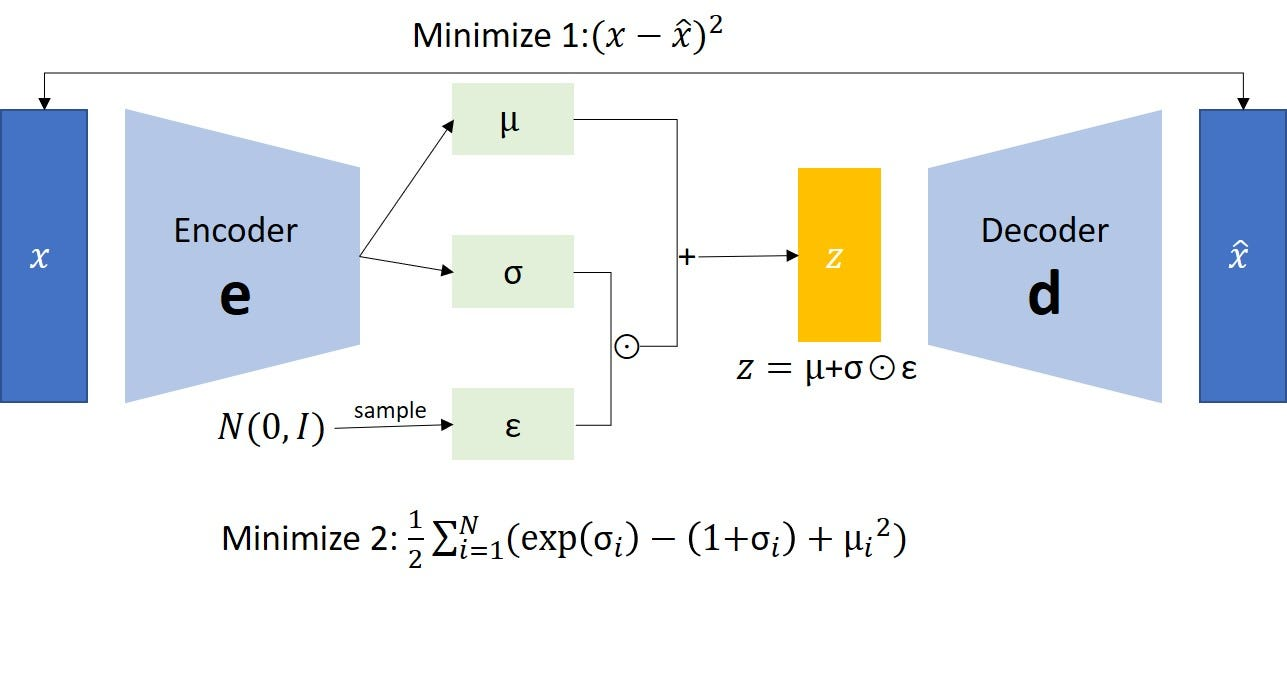 <br>
(VAE image from [this article](https://medium.com/geekculture/variational-autoencoder-vae-9b8ce5475f68). Check it out for more details.)
 - Unlike vanilla and denoise autoencoders, VAE learns **parameters (mean $\boldsymbol{\mu}$ and variance $\boldsymbol{\sigma}$ ) of latent representation feature's probability distribution** intead of just fixed numbers of feature representation.
 - As we can see from the graph above, the latent space is defined by a mean ($\boldsymbol{\mu}$) and variance ($\boldsymbol{\sigma}$). The randomness in this space arises from both the variance ($\boldsymbol{\sigma}$) added to $\boldsymbol{\mu}$ and the noise ($\boldsymbol{\epsilon}$) scaled by $\boldsymbol{\sigma}$. This particular setup enables the model to generate similar but not identical outputs to the input data. 
 - VAE loss = KL loss + Reconstruction loss. <br> 
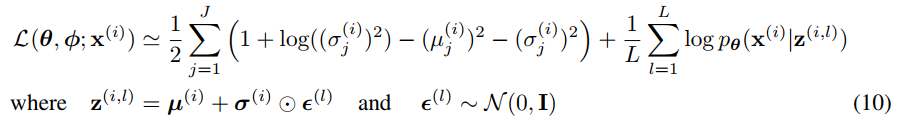 <br>
 (Formula image from [stackoverflow](https://stackoverflow.com/questions/45564706/why-the-loss-of-variational-autoencoder-in-many-implementations-have-opposite-si). Check it out for more details.) <br>
 - We've discussed reconstruction loss before, all autoencoders usually have this loss function. The additional part is the KL loss (Kullback-Leibler Divergence loss): \begin{equation}\frac{1}{2} \sum_{i=1}^{J} \left(1 + \log((\sigma_j^{(i)})^2) - (\mu_j^{(i)})^2 - (\sigma_j^{(i)})^2\right) \end{equation} 
 - The **KL loss measures the distance of two data distribution**. The similar the distribution, the less then KL loss. By aiming to minimizing the KL loss as well, the model is forced to generate outputs that have similar distributions to real training input
    


<div style="background-color: #f4f4f4; padding: 10px;">
<span style="font-size: larger; color: black">
    
 
## <font color="#075674" face="Comic Sans MS">GANs</font>    

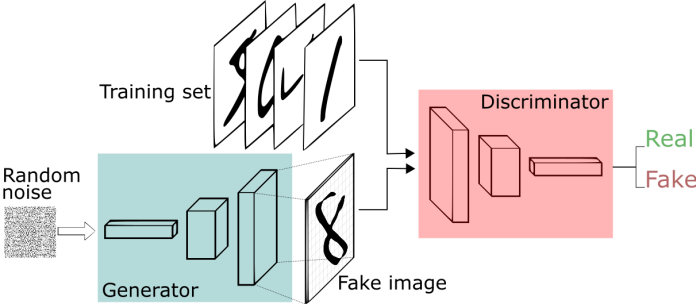<br>
(GANS image from [this article](https://bdtechtalks.com/2018/05/28/generative-adversarial-networks-artificial-intelligence-ian-goodfellow/). Check it out for more details.) 
    
- Generative Adversarial Networks (GANs) is one another family of generative models. They are similar to VAEs in their role as **generative models aimed at understanding the underlying distribution of a dataset and generating new data samples**. However, unlike VAEs, which focus on learning the parameters (mean $\boldsymbol{\mu}$ and variance $\boldsymbol{\sigma}$) of a latent representation feature's probability distribution, GANs **employ a distinctive approach utilizing a generator and a discriminator network**.
- An important part of GAN is **adversarial training**, which uses both **generative approach and creating an adversarial task** which classify the image (real or fake).
- First **generator** tries to generate a fake image from a **random noise (called latent space**). And initially, the generator wouldn't be good at it (so it will just output some noisy like images that are the same size as the real images). 
- Then, at batch iterations, both real and fake images would be sent to discriminator. The **discriminator's job** is to correctly **classify the images as fake or real**. And initially, the discriminator won't do a good job too because the parameters haven't been trained. 
- This is also type of **self-supervision**, which we can create labels already by trying to tell if the images are fake or real (the **surrogate task**)
- After self-supervision, the discriminator can update it's weight. And, it also update the generator's weight. GANs use **Gradient Descent**, which is to minimize the loss for discriminator and **Gradient Ascent** for Generator, which is to maximize the loss.
- Overtime, both of the generator and discriminator would get smarter. And eventually, the generator can generator real-looking images and the discriminator would do good job to tell if the image is fake or real.
- It's important to know the generator and the discriminator compete with each other as well as need to **achieve a balance between each other** (which can be one challenge part of GAN training in practice). 
    - If the discriminator outperforms the generator too quickly,it would be too challenging for the generator to improve and produce realistic samples. This may lead to what's called **"mode collapse"**, where the generator fails to explore the entire data distribution and produces limited varieties of samples. That is, generated images converge to the same image (the same optimal point). Although full mode collapse is not common, partial collapse happens often. 
    - If the generator outperforms the discriminator too quickly, it may generate samples that are too realistic, causing the discriminator to struggle to distinguish between real and fake samples. In this case, the discriminator fails to provide useful gradients to the generator for improvement.
- We know [binary cross-entropy](https://towardsdatascience.com/where-did-the-binary-cross-entropy-loss-function-come-from-ac3de349a715#:~:text=Using%20a%20concept%20called%20maximum,product%20of%20multiple%20Bernoulli%20trials.) is used for binary classifications loss function. It is derived by maximize the [maximum likelihood](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) of existing samples with bernoulli distribution (1 or 0). The **Minimax objective function**, which is used in the original GAN paper, is motivated by binary cross-entropy. But note there are 2 parts for discriminator D and 1 part for generator G. 
    - For discriminator D, the first part is when the label is real (real image is sent to discriminator), here the discriminator want logD(x) to be 1 (probability the real Monet painting discriminated to be real Monet painting to be 1) or to **maximize** the expected value of [logD(x)]. The second part is when the label (G(z) instead of x) is sent to the discriminator D, we want D(G(z)) to be 0 (discriminator think the probability G(z) is a real Monet painting to be 0) or **maximize** the expected value of [log(1-D(G(z))]. So, discriminator cares to both maximize expected value of [logD(x)] and [log(1-D(G(z))]. So, gradient descent is used for discriminator D, which is to minimize the loss function.
    - For generator G, we want the discrimator to think G(z) as 1 (real image). That is, generator G only cares to **minimize** the expected value of  [log(1-D(G(z))] or maximize the second part of loss function (gradient ascent). (Only the second part of loss function below also belongs to generator G to minimize, while both parts belong to discriminator D to maximize.) <br>
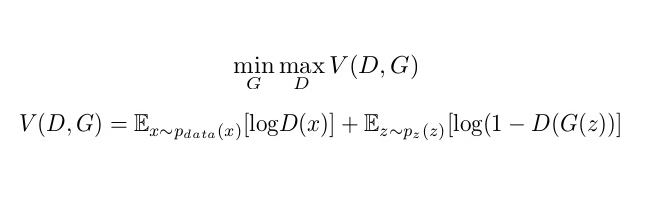 <br>
    
    (Formula image from [Analytics Vidhya](https://www.analyticsvidhya.com/blog/2021/06/a-detailed-explanation-of-gan-with-implementation-using-tensorflow-and-keras/). Check it out for more details. The term Ex~pdata(x) [log D(x)] can be read as expected value of log(D(x)) when x is sampled from pdata(x) and similar for the second term.) <br>
    
- Because we have a bunch of (instead of just one) images, and all we tell the model is whether the image resembel the real one or not instead of let the model have any pixel to pixel comparison of real vs. fake images like the reconstruction loss function part of autoencoder does (although VAE has another part in loss functions for distribution similarity but things work in different ways as mentioned above), we forced the GAN model to learn the underlying distribution of a dataset and generating new data samples that has same distribution. 
- For GANS, not using explicit likelihood (based on "real" distibution functions using $\boldsymbol{\mu}$ and $\boldsymbol{\sigma}$ ) in loss functions and not use distribution functions (like VAEs) has both pros and cons.
    - Not like VAEs, which basically use distriubtion function, may struggle to capture complex data distributions, leading to limited diversity in generated samples, **GANs maybe capable to produce diverse outputs by learning the complex data distribution**. This diversity enables the generation of various samples with different characteristics.
    - Not like VAEs, which prioritize reconstruction loss over sample quality may more often produce samples with less sharpness and realism, **GANs maybe capable to produce more real looking, high quality images** because that's what GANs loss function really focus on.
    - As there is no explicit likelihood function to measure model performance in GANs, **evaluating the performance can be challenging**. Metrics like **Inception Score and Frechet Inception Distance are commonly used but have limitations**. In comparison, VAEs explicitly model the likelihood of the data, providing a probabilistic framework for generative modeling. This makes them well-suited for tasks requiring uncertainty estimation and likelihood evaluation.
- The **original GAN paper** use this **minimax loss function** but later there are **some other loss function that could make the model more stable** (such as WGAN-GP)

<div style="background-color: #f4f4f4; padding: 10px;">
<span style="font-size: larger; color:black">

     
## <font color="#075674" face="Comic Sans MS">DCGAN</font>    

- **Deep Convolutional Generative Adversarial Network (DCGAN)**: One of the most popular network design for GANs (or originated from). It leverages deep **convolutional neural networks** (CNNs) for both the generator and discriminator networks that are good at produce high-quality synthetic images:
   - **Gets rid of max-pooling which destroys spatial information and hurts the image quality**.
   - **Replaces all max pooling with convolutional stride**. Convolutional stride are used in the discriminator to **downsample the input images**.
   - **Transposed convolutions** (also known as deconvolutions) are used in the generator to **upsample the latent input into higher-resolution images**.   
   - **Batch Normalization**: Batch normalization is applied to the activations of both the generator and discriminator networks, helping stabilize training and accelerate convergence.
   - No Fully Connected Layers: DCGANs typically **avoid fully connected layers** in favor of using **global average pooling** in the **discriminator** and **reshaping** operations in the **generator**.
   - Activation Functions: Commonly used activation functions like **ReLU** (Rectified Linear Unit) are employed in the **hidden layers** of both networks, with the exception of the **output layer of the generator** (which often uses **Tanh**) and the **output layer of the discriminator** (which often uses **Sigmoid**).


<div style="background-color: #f4f4f4; padding: 10px;">
<span style="font-size: larger; color: black">

## <font color="#075674" face="Comic Sans MS">CycleGAN</font>    

  (For details, it's good to read the [original paper](https://arxiv.org/abs/1703.10593). Surprisingly, it's not very hard to read. Also, I find [this article](https://www.scaler.com/topics/cyclegan/) to be really helpful.)
  - CycleGAN can **learn to translate images from one domain to another without the need for paired examples**. For example, we won't have the real photos relate to the corresponding Monet paintings. Rather, CycleGAN can learn the style of images in one domain and apply the style to images in another domain. 
  - One part is related to **adversarial training** (as many other GANs), which only care if the generated/transfered images from one domain resemble the real images in another domain. There will be 2 generators (F & G) and 2 discriminators (Dy & Dx using **adversary losses**):
    - It uses a generator **G to convert images in X domain to Y domain** (real pictures to Monet style paintings). Here, X domain images can be the images transfered from y too (photos can be either original real photos or those "photos" generated/transfered from Monet paintings). A **discriminator Dy** is used to make sure the transfer image G(X) (or G(F(Y)) does resemble images in Y domain. (Ex: Transfered photo to Monet style painting do look like real Monet paintings).
    - Similarly, it uses another generator **F to convert images in Y domain to X domain** (Monet paintings or transfered "Monet paitings" from real photos to real photos). A **discriminator Dx** is used to make sure the generated/transfered images F(Y) (or F(G(X)) do resemble images in X domain (generated photos or 'photos' do look like real photos).
  - Wait, after I transfer a photo to Monet style paining using generator G, yup it does look like a real Monet painting, but what if the generated image doesn't look like my original photo anymore (and vice vera for photo generator F)? That is, what if generator G transfered my photo to something completely not related to my original photo? 🙀 No worry, CycleGAN does argue that the learned mapping functions should be cycle-consistent. **Cycle consistency Loss**, another part of CycleGAN loss function comes to help here to make sure the generated monet style paintings do look like the original photo when transfer back to the photo (and vice versa). There will be 2 cycle consistency losses to be monitored:
    - **Forward cycle consistency loss**: to monitor for each images x from domain X, the image translation cycle should be able to bring x back to the original image (when we transfer Monet style painting generated by a real photo back to photo, it should look like the original photo). That is, F(G(x)) should be close to x.
    - **Backward cycle consistency loss**: Similar to the forward one, it monitors G(F(y)) to be close to y.
    
  - Finally, here is the objective function (model's goal to maximize or minimize):<br>
    - First part is for **adversary training**. It is to ensure the transfered images resemble the transfered domain images well:<br>
      - We have adversary objective part for generator G and distriminator Dy. Note for generator G, it wants the generated image G(x) to look like 1 to discriminator Dy. That is, wants D(G(x)) to be 1 or minimize the expected value of [D(G(x))-1]^2. For Discriminator Dy, it wants D(G(x)) to be 0 and D(y) (when real Monet painitng y sent to discriminator) to be 1:<br>
    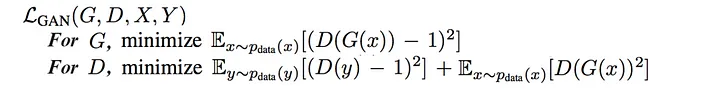 <br>
      - Similary, there will be an adversary objective function for generator F and discrimator Dx.
    - Second part is for **cycle consistency** (**reconstruction cost**), which measures the L1-norm reconstruction cost for the real image (x → y → reconstructed x) and the Monet paintings (y → x → reconstructed y). This part ensures that the translated images maintain their original content when mapped back to their original domain. The cycle consistency loss for both G and F: <br>
    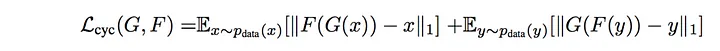 <br>

    - Adding adversary and cycle consistency objective functions together, we get the final objective function. We have $\lambda$ here to control the relative importance of the two objective parts: <br>
    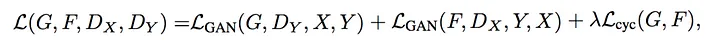<br>
    (Images from [this article](https://jonathan-hui.medium.com/gan-cyclegan-6a50e7600d7), it has more details of CycleGAN as well. )
  - Lastly, to reduce model oscillation, instead of updating the discriminator using the last generated image by the latest generators, CycleGAN retains a history of the last 50 generated images to train the discriminator. That is, the discriminator will not be overzealous in beating the current generator. It needs to beat the last 50 generators to create a more generalized solution.




## <font face="Comic Sans MS" color=#ad2004 >To continuou, [HERE](https://www.kaggle.com/code/jieshends2020/gan-painting-part-2) is part 2 of the notebook.</font>